In [3]:
import os
from shutil import copyfile
from glob import glob
import numpy as np
%cd $DATA_HOME_DIR/train

%pwd
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid' + shuf[i])

/home/ubuntu/wbc/data_cd/redux/train


In [1]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data_cd/redux'

In [2]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results\
    
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/wbc/data_cd/redux


In [4]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/wbc/data_cd/redux/sample/train
mv: cannot stat 'cat.*.jpg': No such file or directory
mv: cannot stat 'dog.*.jpg': No such file or directory
/home/ubuntu/wbc/data_cd/redux/sample/valid
mv: cannot stat 'cat.*.jpg': No such file or directory
mv: cannot stat 'dog.*.jpg': No such file or directory
/home/ubuntu/wbc/data_cd/redux/valid
mv: cannot stat 'cat.*.jpg': No such file or directory
mv: cannot stat 'dog.*.jpg': No such file or directory
/home/ubuntu/wbc/data_cd/redux/train


In [10]:
%pwd
%cd /home/ubuntu/wbc/

/home/ubuntu/wbc


In [12]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from resnet50 import Resnet50

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline
print ("Library Loaded")

Library Loaded


In [27]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = '/home/ubuntu/wbc/data_cd/redux/test/'
 #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path='/home/ubuntu/wbc/data_cd/redux/train'
valid_path='/home/ubuntu/wbc/data_cd/redux/valid'

/home/ubuntu/wbc/data_cd/redux


In [14]:
resnet=Resnet50(include_top=False).model

/home/ubuntu/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ubuntu/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ubuntu/anaconda3/lib/python3.5/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [15]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=20

In [16]:
resnet.output_shape[1:]

(2048, 7, 7)

In [28]:
#Finetune the model
batches = get_batches(train_path,shuffle=False, batch_size=batch_size)
val_batches = get_batches(valid_path, batch_size=batch_size*2,shuffle=False)

(val_classes,trn_classes,val_labels,trn_labels,val_filenames,
filenames,test_filenames)=get_classes(path)


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [29]:
val_features=resnet.predict_generator(val_batches,val_batches.nb_sample)

In [ ]:
import bcolz
save_array(results_path+"val_resnet_conv.bc",val_features)

In [30]:
trn_features=resnet.predict_generator(batches,batches.nb_sample)

In [ ]:
# save_array(results_path+"trn_resnet_conv.bc",trn_features)

In [31]:
def get_fc_layers(p):
    return [
        BatchNormalization(axis=1,input_shape=resnet.output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(1024,activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(1024,activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(2,activation='softmax')
        
    ]

In [32]:
model=Sequential(get_fc_layers(0.5))

In [33]:
model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [96]:
model.fit(trn_features,trn_labels,nb_epoch=2,batch_size=batch_size,validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/2
  512/23000 [..............................] - ETA: 651s - loss: 0.0078 - acc: 0.9980

KeyboardInterrupt: 

In [35]:
def get_ap_layers(p):
    return [
        GlobalAveragePooling2D(input_shape=resnet.output_shape[1:]),
        Dropout(p),
        Dense(2,activation='softmax')
    ]

In [49]:
model1=Sequential(get_ap_layers(0.01))

th


In [50]:
model1.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [85]:
model1.fit(trn_features,trn_labels,nb_epoch=10,batch_size=100,
          validation_data=(val_features,val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 7s - loss: 0.0208 - acc: 0.9926 - val_loss: 0.0386 - val_acc: 0.9860
Epoch 2/10
23000/23000 [==============================] - 7s - loss: 0.0184 - acc: 0.9940 - val_loss: 0.0318 - val_acc: 0.9915
Epoch 3/10
23000/23000 [==============================] - 7s - loss: 0.0166 - acc: 0.9947 - val_loss: 0.0334 - val_acc: 0.9905
Epoch 4/10
23000/23000 [==============================] - 7s - loss: 0.0163 - acc: 0.9950 - val_loss: 0.0371 - val_acc: 0.9905
Epoch 5/10
23000/23000 [==============================] - 7s - loss: 0.0147 - acc: 0.9955 - val_loss: 0.0351 - val_acc: 0.9915
Epoch 6/10
23000/23000 [==============================] - 7s - loss: 0.0127 - acc: 0.9960 - val_loss: 0.0376 - val_acc: 0.9905
Epoch 7/10
23000/23000 [==============================] - 7s - loss: 0.0124 - acc: 0.9961 - val_loss: 0.0439 - val_acc: 0.9885
Epoch 8/10
23000/23000 [==============================] - 7s -

In [52]:
test_batches = get_batches(test_path, batch_size=batch_size*2,shuffle=False)


Found 12500 images belonging to 1 classes.


In [54]:
test_features=resnet.predict_generator(test_batches,test_batches.nb_sample)

In [56]:
pred=model1.predict(test_features)

In [65]:
save_array(results_path + 'test_preds.dat', pred)
save_array(results_path + 'filenames.dat', test_filenames)

In [59]:
#Grab the dog prediction column
isdog = pred[:,1]
print ("Raw Predictions: " + str(isdog[:5]))
print ("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print ("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [  9.9972e-01   9.5801e-01   1.0000e+00   1.8859e-08   7.7649e-03]
Mid Predictions: [ 0.4089  0.5134  0.5006  0.5247  0.5787  0.5057  0.4407  0.4047  0.548   0.4744  0.5096  0.4888
  0.5402  0.5035  0.4622  0.5019  0.4981  0.5696  0.4702  0.4838  0.5186  0.5057  0.5118  0.5988
  0.5227  0.4416  0.4943  0.4681  0.5519  0.5573  0.5747  0.4419  0.5113  0.4193  0.4986  0.4877
  0.5214  0.5354  0.5822  0.4966  0.4766  0.4206  0.585   0.4896  0.4127  0.5711  0.4773  0.5889
  0.4918  0.4569  0.5277  0.5929]
Edge Predictions: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]


In [66]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)
pred = load_array(results_path + 'test_preds.dat')
T_filenames = load_array(results_path + 'filenames.dat')

In [67]:
T_filenames

array(['unknown/377.jpg', 'unknown/17.jpg', 'unknown/2452.jpg', ..., 'unknown/2093.jpg',
       'unknown/9990.jpg', 'unknown/1619.jpg'], 
      dtype='<U17')

In [69]:
#Extract imageIds from the filenames in our test/unknown directory 
#filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in T_filenames])
print (ids)

[ 377   17 2452 ..., 2093 9990 1619]


In [70]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  3.7700e+02,   9.5000e-01],
       [  1.7000e+01,   9.5000e-01],
       [  2.4520e+03,   9.5000e-01],
       [  1.1565e+04,   5.0000e-02],
       [  2.0430e+03,   5.0000e-02]])

In [71]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission18.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/wbc/data_cd/redux


In [72]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data_cd/redux/'+submission_file_name)

/home/ubuntu/wbc


/home/ubuntu/wbc/data_cd/redux/submission18.csv

# Validation Check and Confusion Matrix

In [86]:
prob=model1.predict(val_features)

In [87]:
filenamesa = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = prob[:,0]
our_labels = np.round(1-our_predictions)

In [88]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenamesa[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

In [89]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print ("Found %d correct labels" % len(correct))
idx = permutation(correct)[:n_view]
#plots_idx(idx, our_predictions[idx])

Found 1981 correct labels


In [90]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print ("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
#plots_idx(idx, our_predictions[idx])

Found 19 incorrect labels


In [91]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print ("Found %d confident correct cats labels" % len(correct_cats))
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
#plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 996 confident correct cats labels


In [92]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print ("Found %d confident correct dogs labels" % len(correct_dogs))
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
#plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 985 confident correct dogs labels


In [93]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print ("Found %d incorrect cats" % len(incorrect_cats))
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
   # plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 11 incorrect cats


In [94]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print ("Found %d incorrect dogs" % len(incorrect_dogs))
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    #plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

Found 8 incorrect dogs


In [95]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

print (cm)

[[996   8]
 [ 11 985]]


[[997   7]
 [ 10 986]]


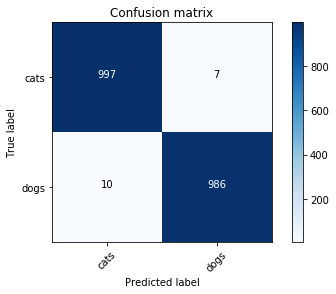

In [84]:
plot_confusion_matrix(cm, val_batches.class_indices)